# Differential expression of near vs not near cells 

This notebook contains code for testing the differential expression of genes near and not near certain effector cells (NSCs, T cells) and characterizing potential leakage/spillover effects (these are controlled for later in the area-restricted proximity effect analysis).

**Associated manuscript figures/tables:**
- Supplementary Figure 6


**Inputs required:**
- `results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad` - AnnData object for coronal sections data with spatial aging clock predictions (generated from `cv_train_clock.py`)


**Conda environment used**: `requirements/merfish.txt`

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import anndata as ad
from scipy.stats import pearsonr, spearmanr, ttest_ind
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style("ticks")
from sklearn.neighbors import BallTree

from scipy.stats import mannwhitneyu, ttest_ind, levene
from statsmodels.stats.multitest import multipletests
from decimal import Decimal

from ageaccel_proximity import *
from clock_preprocessing import *

In [2]:
restricted_celltype_subset = ['Neuron-Excitatory','Neuron-MSN','Astrocyte','Microglia','Oligodendrocyte','OPC','Endothelial','Pericyte','VSMC','Ependymal','Neuroblast','NSC','Macrophage', 'T cell']

celltypes_full = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']

In [3]:
# Distance Cutoff Parameters -- see D1_regional_proximity_distance_cutoffs.ipynb

cutoff = {'CC/ACO': 24.887910095931538, 'CTX_L1/MEN': 25.91425280674148, 'CTX_L2/3': 24.04649324744985, 'CTX_L4/5/6': 27.243990001598508, 'STR_CP/ACB': 21.6499141249257, 'STR_LS/NDB': 20.355186196238336, 'VEN': 17.863153902391776}

## Get cell proximity information

In [4]:
adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad")

normalize_adata(adata, zscore=False)

# compute age acceleration
get_age_acceleration (adata)

# Compute nearest to cell type distances
nearest_distance_to_celltype(adata,
                             celltype_list=pd.unique(adata.obs.celltype).sort_values(),
                             sub_id="mouse_id")

## Differential expression testing

In [5]:
# Compute equal variance test stats

cutoff_multiplier = 1

celltypes = ["T cell", "NSC"]

target_cells = restricted_celltype_subset

###########################
column_values = []
column_headers = []

for celltype in celltypes:
    
    for ct in target_cells:
        
        sub_adata = adata[adata.obs["celltype"]==ct]
        
        # get paired proximity sets
        near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier)
        
        # run test
        
        p_values = []
        log2fcs = []
        
        for gene in adata.var_names:
            
            # get expression of replicates
            x = sub_adata[near_ages=="Near",gene].X.toarray().flatten()
            y = sub_adata[near_ages=="Far",gene].X.toarray().flatten()
            
            # Wilcoxon test
            u, p = mannwhitneyu(x, y)
            
            # Log2 fold change -- map to raw intensities first from log2+1 transform
            lfc = np.log2(np.mean(np.exp(x)-1)/np.mean(np.exp(y)-1))
            
            p_values.append(p)
            log2fcs.append(lfc)
        
        # append results
        column_headers.append(f"{ct} near {celltype} - PValue")
        column_values.append(p_values)
        column_headers.append(f"{ct} near {celltype} - Log2FC")
        column_values.append(log2fcs)
        
# save results dataframe
df = pd.DataFrame(np.vstack(column_values).T, columns=column_headers, index=adata.var_names.values)
df.to_csv("results/proximity/differential_testing_spilloverNearFar_Tcell_NSC.csv")

/local/scratch/edsun/slrmtmp.43817902/ipykernel_23515/580845191.py:43: RuntimeWarning: divide by zero encountered in double_scalars
  lfc = np.log2(np.mean(np.exp(x)-1)/np.mean(np.exp(y)-1))
/local/scratch/edsun/slrmtmp.43817902/ipykernel_23515/580845191.py:43: RuntimeWarning: divide by zero encountered in log2
  lfc = np.log2(np.mean(np.exp(x)-1)/np.mean(np.exp(y)-1))
/local/scratch/edsun/slrmtmp.43817902/ipykernel_23515/580845191.py:43: RuntimeWarning: invalid value encountered in double_scalars
  lfc = np.log2(np.mean(np.exp(x)-1)/np.mean(np.exp(y)-1))


In [25]:
df = pd.read_csv("results/proximity/differential_testing_spilloverNearFar_Tcell_NSC.csv", index_col=0)

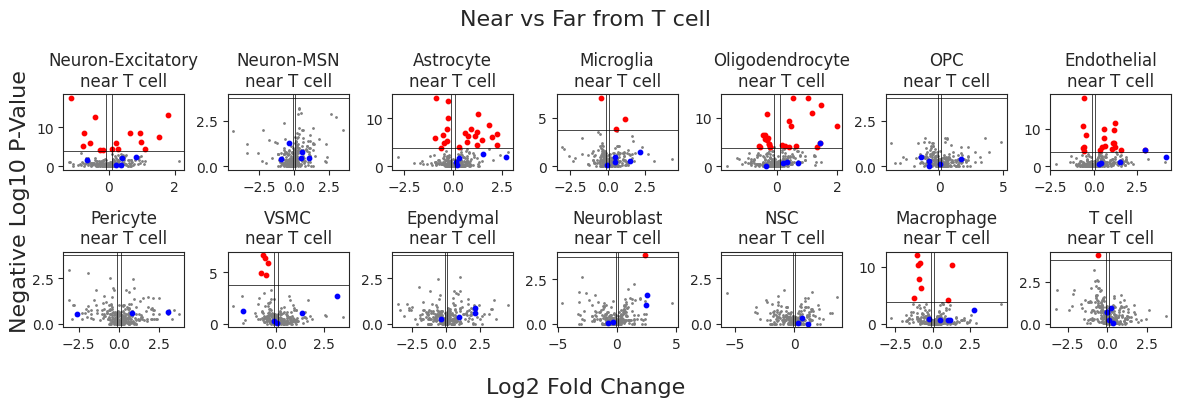

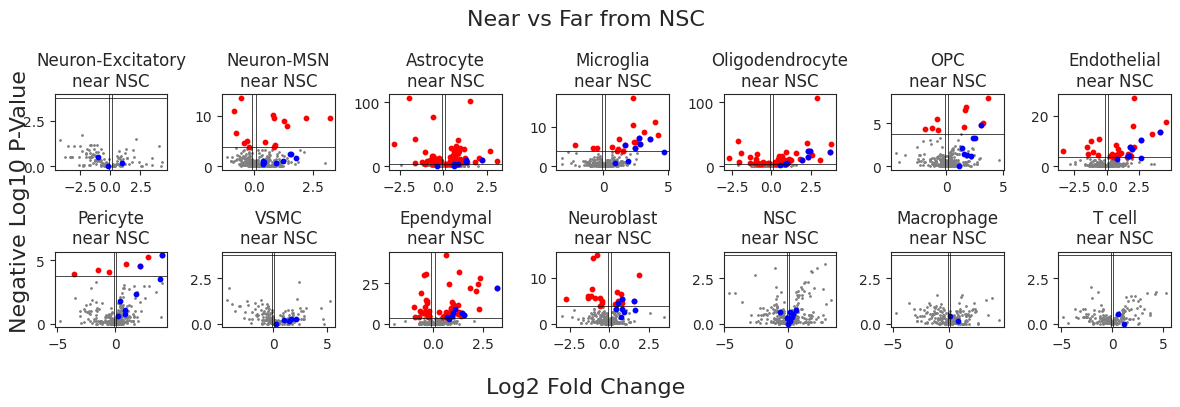

In [28]:
celltypes = ["T cell", "NSC"]

target_cells = restricted_celltype_subset

marker_genes = {
    "T cell": ["Cd3e", "Nkg7", "Ccl5", "Ms4a4b", "Cd3g"],
    "NSC": ["Pclaf", "H2afx", "Rrm2", "Insm1", "Egfr", "Mki67", "Mcm2", "Cdk1"],
}

pvalcutoff = 0.05 / 300
abslog2fc = 0.1


#-----------------------------------------------------------------------


for celltype in celltypes:
            
    nrows = 2
    ncols = 7

    fig, axs = plt.subplots(nrows, ncols, figsize=(12,4), sharex=False, sharey=False)
    
    counter = 0
    for i in range(nrows):
        for j in range(ncols):
    
            ct = target_cells[counter]

            pvals = df[f"{ct} near {celltype} - PValue"]
            log2fcs = df[f"{ct} near {celltype} - Log2FC"]

            # significant masking
            sig_mask = (pvals <= pvalcutoff) & (np.abs(log2fcs) >= abslog2fc)
            marker_mask = df.index.isin(marker_genes[celltype])

            # make plot
            axs[i,j].set_title(f"{ct}\nnear {celltype}", fontsize=12)
            axs[i,j].scatter(log2fcs, -np.log10(pvals), s=1, c="0.5")
            axs[i,j].scatter(log2fcs[sig_mask], -np.log10(pvals)[sig_mask], s=10, c="r", label="Differentially expressed")
            axs[i,j].scatter(log2fcs[marker_mask], -np.log10(pvals)[marker_mask], s=10, c="b", label=f"{celltype} marker")
            axs[i,j].axvline(-abslog2fc, color='k', linestyle='-', linewidth=0.5)
            axs[i,j].axvline(abslog2fc, color='k', linestyle='-', linewidth=0.5)
            axs[i,j].axhline(-np.log10(pvalcutoff), color='k', linestyle='-', linewidth=0.5)

            counter += 1

    # make figure
    fig.suptitle(f"Near vs Far from {celltype}", fontsize=16)
    fig.supxlabel("Log2 Fold Change", fontsize=16)
    fig.supylabel("Negative Log10 P-Value", fontsize=16)
    fig.tight_layout()
    plt.savefig(f"plots/proximity/volcano_combined_{celltype}.pdf", bbox_inches='tight')
    plt.show()

### For area-restricted proximity matching

In [14]:
# Compute equal variance test stats

cutoff_multiplier = 2

celltypes = ["T cell", "NSC"]

target_cells = restricted_celltype_subset

###########################
column_values = []
column_headers = []

for celltype in celltypes:
    
    for ct in target_cells:
        
        sub_adata = adata[adata.obs["celltype"]==ct]
        
        # get paired proximity sets
        near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier,
                                                ring_width=15)
        
        # run test
        
        p_values = []
        log2fcs = []
        
        for gene in adata.var_names:
            
            # get expression of replicates
            x = sub_adata[near_ages=="Near",gene].X.toarray().flatten()
            y = sub_adata[near_ages=="Far",gene].X.toarray().flatten()
            
            # Wilcoxon test
            u, p = mannwhitneyu(x, y)
            
            # Log2 fold change -- map to raw intensities first from log2+1 transform
            lfc = np.log2(np.mean(np.exp(x)-1)/np.mean(np.exp(y)-1))
            
            p_values.append(p)
            log2fcs.append(lfc)
        
        # append results
        column_headers.append(f"{ct} near {celltype} - PValue")
        column_values.append(p_values)
        column_headers.append(f"{ct} near {celltype} - Log2FC")
        column_values.append(log2fcs)
        
# save results dataframe
df = pd.DataFrame(np.vstack(column_values).T, columns=column_headers, index=adata.var_names.values)
df.to_csv("results/proximity/differential_testing_spilloverNearFar_Tcell_NSC_2RING15.csv")

/local/scratch/edsun/slrmtmp.43817902/ipykernel_23515/1543994421.py:38: RuntimeWarning: divide by zero encountered in log2
  lfc = np.log2(np.mean(np.exp(x)-1)/np.mean(np.exp(y)-1))
/local/scratch/edsun/slrmtmp.43817902/ipykernel_23515/1543994421.py:38: RuntimeWarning: divide by zero encountered in double_scalars
  lfc = np.log2(np.mean(np.exp(x)-1)/np.mean(np.exp(y)-1))
/local/scratch/edsun/slrmtmp.43817902/ipykernel_23515/1543994421.py:38: RuntimeWarning: invalid value encountered in double_scalars
  lfc = np.log2(np.mean(np.exp(x)-1)/np.mean(np.exp(y)-1))


In [29]:
df = pd.read_csv("results/proximity/differential_testing_spilloverNearFar_Tcell_NSC_2RING15.csv", index_col=0)

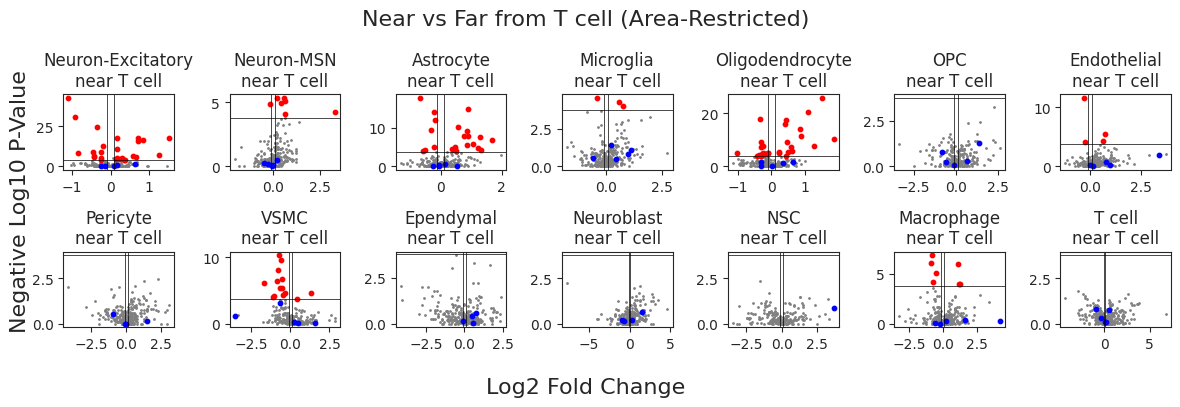

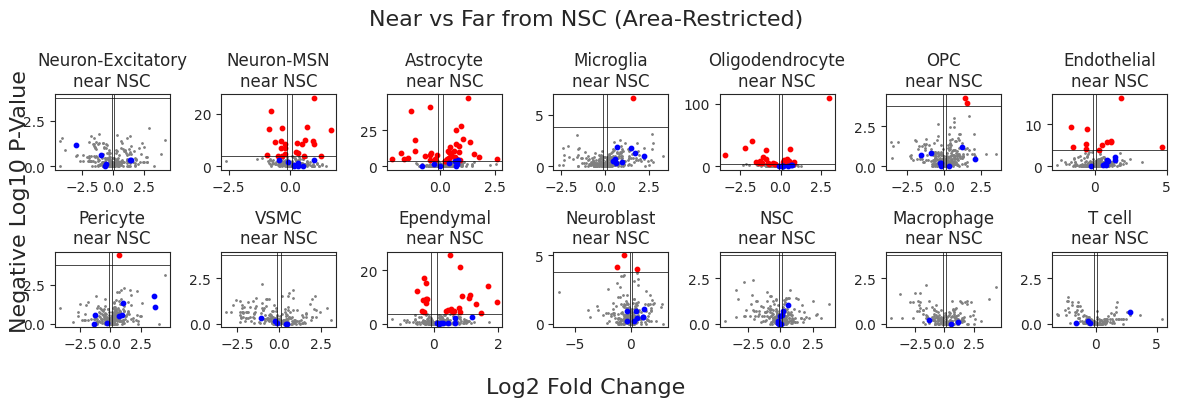

In [30]:
celltypes = ["T cell", "NSC"]

target_cells = restricted_celltype_subset

marker_genes = {
    "T cell": ["Cd3e", "Nkg7", "Ccl5", "Ms4a4b", "Cd3g"],
    "NSC": ["Pclaf", "H2afx", "Rrm2", "Insm1", "Egfr", "Mki67", "Mcm2", "Cdk1"],
}

pvalcutoff = 0.05 / 300
abslog2fc = 0.1


#-----------------------------------------------------------------------


for celltype in celltypes:
            
    nrows = 2
    ncols = 7

    fig, axs = plt.subplots(nrows, ncols, figsize=(12,4), sharex=False, sharey=False)
    
    counter = 0
    for i in range(nrows):
        for j in range(ncols):
    
            ct = target_cells[counter]

            pvals = df[f"{ct} near {celltype} - PValue"]
            log2fcs = df[f"{ct} near {celltype} - Log2FC"]

            # significant masking
            sig_mask = (pvals <= pvalcutoff) & (np.abs(log2fcs) >= abslog2fc)
            marker_mask = df.index.isin(marker_genes[celltype])

            # make plot
            axs[i,j].set_title(f"{ct}\nnear {celltype}", fontsize=12)
            axs[i,j].scatter(log2fcs, -np.log10(pvals), s=1, c="0.5")
            axs[i,j].scatter(log2fcs[sig_mask], -np.log10(pvals)[sig_mask], s=10, c="r", label="Differentially expressed")
            axs[i,j].scatter(log2fcs[marker_mask], -np.log10(pvals)[marker_mask], s=10, c="b", label=f"{celltype} marker")
            axs[i,j].axvline(-abslog2fc, color='k', linestyle='-', linewidth=0.5)
            axs[i,j].axvline(abslog2fc, color='k', linestyle='-', linewidth=0.5)
            axs[i,j].axhline(-np.log10(pvalcutoff), color='k', linestyle='-', linewidth=0.5)

            counter += 1

    # make figure
    fig.suptitle(f"Near vs Far from {celltype} (Area-Restricted)", fontsize=16)
    fig.supxlabel("Log2 Fold Change", fontsize=16)
    fig.supylabel("Negative Log10 P-Value", fontsize=16)
    fig.tight_layout()
    plt.savefig(f"plots/proximity/volcano_combined_2RING15_{celltype}.pdf", bbox_inches='tight')
    plt.show()